In [112]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import arviz as az
import pymc3 as pm
from causalgraphicalmodels import CausalGraphicalModel
from copy import deepcopy
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'svg'

In [3]:
np.set_printoptions(formatter={float: lambda x: '{:,.3f}'.format(x)})
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))

# The Many Variables & The Spurious Waffles

## Codes 

### Code 5.1

In [4]:
d = pd.read_csv('../data/WaffleDivorce.csv', sep=';')

In [5]:
def create_standardizer_destandardizer(s: np.ndarray) -> np.ndarray:
    return lambda x: (x - s.mean()) / s.std(), lambda x: (x * s.std()) + s.mean()

In [6]:
std_D, dstd_D = create_standardizer_destandardizer(d['Divorce'])
std_M, dstd_M = create_standardizer_destandardizer(d['Marriage'])
std_A, dstd_A = create_standardizer_destandardizer(d['MedianAgeMarriage'])

In [7]:
d['D'] = std_D(d['Divorce'])
d['M'] = std_M(d['Marriage'])
d['A'] = std_A(d['MedianAgeMarriage'])

### Code 5.2

In [8]:
d['MedianAgeMarriage'].std()

1.2436303013880823

In [9]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,D,M,A
0,Alabama,AL,4.780,25.300,20.200,1.270,12.700,0.790,128,1,435080,964201,0.450,1.654,0.023,-0.606
1,Alaska,AK,0.710,25.200,26.000,2.930,12.500,2.050,0,0,0,0,0.000,1.544,1.550,-0.687
2,Arizona,AZ,6.330,25.800,20.300,0.980,10.800,0.740,18,0,0,0,0.000,0.611,0.049,-0.204
3,Arkansas,AR,2.920,24.300,26.400,1.700,13.500,1.220,41,1,111115,435450,0.260,2.094,1.655,-1.410
4,California,CA,37.250,26.800,19.100,0.390,8.000,0.240,0,0,0,379994,0.000,-0.927,-0.267,0.600


### Code 5.3

In [10]:
with pm.Model() as m51:
    a = pm.Normal('a', 0, .2)
    bA = pm.Normal('bA', 0, .5)
    sigma = pm.Exponential('sigma', 1)
    mu = a + bA * d['A']
    D = pm.Normal('D', mu, sigma, observed=d['D'])
    prior = pm.sample_prior_predictive(50, model=m51)
    trace_51 = pm.sample()

<ipython-input-10-8016d92d5389>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_51 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


### Code 5.4

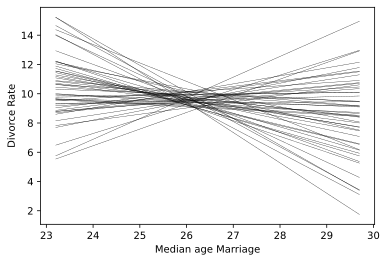

In [11]:
x = std_A(np.linspace(d['MedianAgeMarriage'].min(), d['MedianAgeMarriage'].max(), 50))

fig, ax = plt.subplots()
ax.set_xlabel('Median age Marriage')
ax.set_ylabel('Divorce Rate')

for i in range(len(prior['a'])):
    y = dstd_D(prior['a'][i] + prior['bA'][i] * x)
    ax.plot(dstd_A(x), y, color='black', linewidth=.3)

plt.show()

### Code 5.5

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


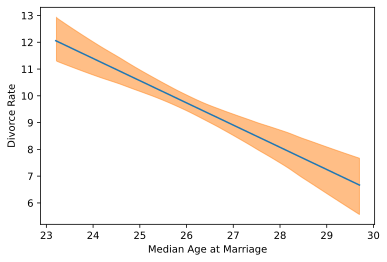

In [12]:
mu_pred = (trace_51['a'] + np.outer(x, trace_51['bA'])).T

fig, ax = plt.subplots()
ax.plot(dstd_A(x), dstd_D(mu_pred).mean(axis=0))
az.plot_hdi(dstd_A(x), dstd_D(mu_pred), hdi_prob=.89, ax=ax)
ax.set_xlabel('Median Age at Marriage')
ax.set_ylabel('Divorce Rate')
plt.show()

### Code 5.6

In [13]:
with pm.Model() as m52:
    a = pm.Normal('a', 0, .2)
    bM = pm.Normal('bM', 0, .5)
    sigma = pm.Exponential('sigma', 1)
    mu = a + bM * d['M']
    D = pm.Normal('D', mu, sigma, observed=d['D'])
    trace_52 = pm.sample()

<ipython-input-13-52fb1aabcd10>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_52 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [14]:
x = std_M(np.linspace(d['Marriage'].min(), d['Marriage'].max(), 50))

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


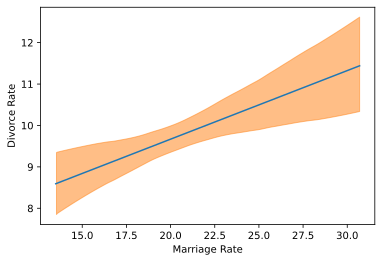

In [15]:
mu_pred = (trace_52['a'] + np.outer(x, trace_52['bM'])).T

fig, ax = plt.subplots()
ax.plot(dstd_M(x), dstd_D(mu_pred).mean(axis=0))
az.plot_hdi(dstd_M(x), dstd_D(mu_pred), hdi_prob=.89, ax=ax)
ax.set_xlabel('Marriage Rate')
ax.set_ylabel('Divorce Rate')
plt.show()

### Code 5.7

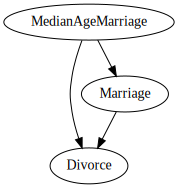

In [16]:
A = 'MedianAgeMarriage'
D = 'Divorce'
M = 'Marriage'

dag1 = CausalGraphicalModel(
    nodes=[A, M, D],
    edges=[
        (A, M),
        (A, D),
        (M, D),
    ]
)

dag1.draw()

In [17]:
d[['A', 'D', 'M']].corr()

,A,D,M
A,1.000,-0.597,-0.721
D,-0.597,1.000,0.374
M,-0.721,0.374,1.000


### Code 5.8-5.9

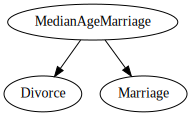

In [18]:
dag2 = CausalGraphicalModel(
    nodes=[A, M, D],
    edges=[
        (A, M),
        (A, D),
    ]
)
dag2.draw()

In [19]:
print('Dag1')
print(dag1.get_distribution())
print('Dag2')
print(dag2.get_distribution())

Dag1
P(MedianAgeMarriage)P(Marriage|MedianAgeMarriage)P(Divorce|MedianAgeMarriage,Marriage)
Dag2
P(MedianAgeMarriage)P(Divorce|MedianAgeMarriage)P(Marriage|MedianAgeMarriage)


In [20]:
print('Dag1')
print(dag1.get_all_independence_relationships())

Dag1
[]


In [21]:
print('Dag2')
print(dag2.get_all_independence_relationships())

Dag2
[('Divorce', 'Marriage', {'MedianAgeMarriage'})]


### Code 5.10

In [22]:
with pm.Model() as model_53:
    a = pm.Normal('a', 0, .2)
    bA = pm.Normal('bA', 0, .5)
    bM = pm.Normal('bM', 0, .5)
    mu = a + bA*d['A'] + bM*d['M']
    sigma = pm.Exponential('sigma', 1)
    D = pm.Normal('D', mu, sigma, observed=d['D'])
    
    prior_53 = pm.sample_prior_predictive(100)
    trace_53 = pm.sample(draws=1000, tune=10_000)

<ipython-input-22-e8ee2e8d7113>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_53 = pm.sample(draws=1000, tune=10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 2 chains for 10_000 tune and 1_000 draw iterations (20_000 + 2_000 draws total) took 19 seconds.


In [23]:
az.summary(trace_53, hdi_prob=.89, kind='stats')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.005,0.107,-0.161,0.180
bA,-0.609,0.156,-0.845,-0.354
bM,-0.059,0.154,-0.300,0.192
sigma,0.826,0.085,0.695,0.958


### Code 5.11

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


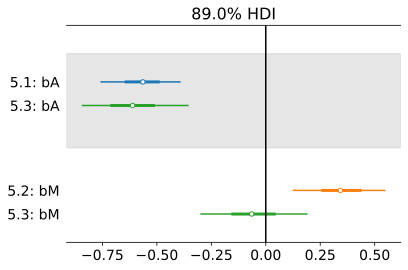

In [24]:
fig, ax = plt.subplots()
az.plot_forest(
    [trace_51, trace_52, trace_53],
    var_names=['bA', 'bM'],
    model_names=['5.1', '5.2', '5.3'],
    combined=True,
    hdi_prob=.89,
    ax=ax
)
ax.axvline(0, color='black')
plt.show()

### Code 5.12

In [25]:
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

### Code 5.13

In [26]:
with pm.Model() as model_54:
    a = pm.Normal('a', 0, .2)
    bAM = pm.Normal('bAM', 0, .5)
    mu = a + bAM*d['A']
    sigma = pm.Exponential('sigma', 1)
    M = pm.Normal('M', mu, sigma, observed=d['M'])
    trace_54 = pm.sample()

<ipython-input-26-77341f1a68df>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_54 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAM, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


### Code 5.14

In [27]:
mu = (trace_54['a'] + np.outer(d['A'], trace_54['bAM'])).T
mu_mean = mu.mean(axis=0)
mu_resid = d['M'] - mu_mean

### Code 5.15

In [28]:
mu = (trace_53['a'] + np.outer(d['A'], trace_53['bA']) + np.outer(d['M'], trace_53['bM'])).T
mu_mean = mu.mean(axis=0)
mu_pi = az.hdi(mu, hdi_prob=.89)

D_sim = stats.norm(mu.T, trace_53['sigma']).rvs().T
D_pi = az.hdi(D_sim, hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


In [29]:
mu.shape, D_sim.shape

((2000, 50), (2000, 50))

In [30]:
mu_pi.shape, D_pi.shape

((50, 2), (50, 2))

### Code 5.16

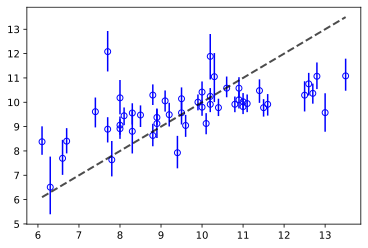

In [31]:
fig, ax = plt.subplots()
seq = np.linspace(d['Divorce'].min(), d['Divorce'].max(), 50)
ax.plot(seq, seq, color='black', linewidth=2, linestyle='--', alpha=.7)
ax.scatter(d['Divorce'], dstd_D(mu_mean), facecolors='none', edgecolors='blue')
ax.vlines(d['Divorce'], dstd_D(mu_pi[:, 0]), dstd_D(mu_pi[:, 1]), color='blue')
plt.show()

### Code 5.18

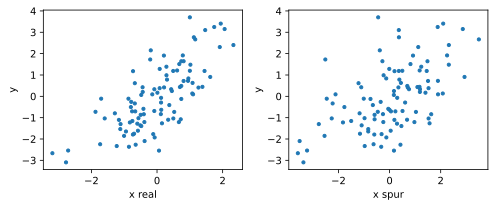

In [32]:
N = 100
x_real = stats.norm().rvs(N)
x_spur = stats.norm(x_real).rvs()
y = stats.norm(x_real).rvs()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

ax1.scatter(x_real, y, s=10)
ax1.set_ylabel('y')
ax1.set_xlabel('x real')

ax2.scatter(x_spur, y, s=10)
ax2.set_ylabel('y')
ax2.set_xlabel('x spur')

fig.tight_layout()
plt.show()

### Code 5.19

In [33]:
with pm.Model() as model_53A:
    a = pm.Normal('a', 0, .2)
    bA = pm.Normal('bA', 0, .5)
    bM = pm.Normal('bM', 0, .5)
    mu = a + bA*d['A'] + bM*d['M']
    sigma = pm.Exponential('sigma', 1)
    D = pm.Normal('D', mu, sigma, observed=d['D'])    
    
    aM = pm.Normal('aM', 0, .2)
    bAM = pm.Normal('bAM', 0, .5)
    mu_M = a + bAM*d['A']
    sigma_M = pm.Exponential('sigma_M', 1)
    M = pm.Normal('M', mu_M, sigma_M, observed=d['M'])
    
    trace_53A = pm.sample(1000, tune=10000)

<ipython-input-33-45c808277faa>:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_53A = pm.sample(1000, tune=10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_M, bAM, aM, sigma, bM, bA, a]


Sampling 2 chains for 10_000 tune and 1_000 draw iterations (20_000 + 2_000 draws total) took 22 seconds.


In [34]:
az.summary(trace_53A, kind='stats', hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.001,0.070,-0.115,0.105
bA,-0.615,0.157,-0.889,-0.394
bM,-0.071,0.157,-0.303,0.188
aM,0.009,0.199,-0.289,0.339
bAM,-0.692,0.093,-0.848,-0.553
sigma,0.821,0.086,0.694,0.953
sigma_M,0.709,0.071,0.587,0.807


### Code 5.20

In [35]:
A_seq = np.linspace(-2, 2, 50)

### Code 5.21

In [36]:
M_mu_seq = trace_53A['aM'] + np.outer(A_seq, trace_53A['bAM'])
M_sim_seq = stats.norm(M_mu_seq, trace_53A['sigma_M']).rvs()

In [37]:
D_mu_seq = trace_53A['a'] + np.outer(A_seq, trace_53A['bA']) + np.multiply(M_sim_seq, trace_53A['bM'])
D_sim_seq = stats.norm(D_mu_seq, trace_53A['sigma']).rvs()

### Code 5.22

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


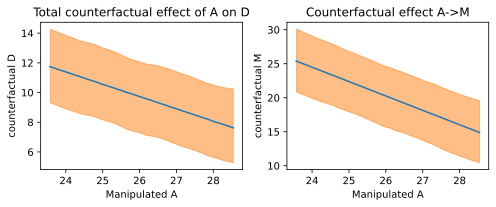

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

ax1.set_title('Total counterfactual effect of A on D')
ax1.set_xlabel('Manipulated A')
ax1.set_ylabel('counterfactual D')
ax1.plot(dstd_A(A_seq), dstd_D(D_mu_seq.mean(axis=1)))
az.plot_hdi(dstd_A(A_seq), dstd_D(D_sim_seq.T), hdi_prob=.89, ax=ax1)

ax2.set_title('Counterfactual effect A->M')
ax2.set_xlabel('Manipulated A')
ax2.set_ylabel('counterfactual M')
ax2.plot(dstd_A(A_seq), dstd_M(M_mu_seq.mean(axis=1)))
az.plot_hdi(dstd_A(A_seq), dstd_M(M_sim_seq.T), hdi_prob=.89, ax=ax2)

fig.tight_layout()
plt.show()

### Code 5.23

In [39]:
A_seq = std_A(np.array([20, 30]))

In [40]:
M_mu_seq = trace_53A['aM'] + np.outer(A_seq, trace_53A['bAM'])
M_sim_seq = stats.norm(M_mu_seq, trace_53A['sigma_M']).rvs()

In [41]:
D_mu_seq = trace_53A['a'] + np.outer(A_seq, trace_53A['bA']) + np.multiply(M_sim_seq, trace_53A['bM'])
D_sim_seq = stats.norm(D_mu_seq, trace_53A['sigma']).rvs()

In [42]:
(D_sim_seq[1, :] - D_sim_seq[0, :]).mean()

-4.58237572234024

In [43]:
(dstd_D(D_sim_seq[1, :]) - dstd_D(D_sim_seq[0, :])).mean()

-8.343653418908055

### Code 5.24

In [44]:
M_seq = np.linspace(-2, 2, 50)
D_mu_seq = trace_53A['a'] + 0*trace_53['bA'] + np.outer(M_seq, trace_53A['bM']) 
D_sim_seq = stats.norm(D_mu_seq, trace_53A['sigma']).rvs().T

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


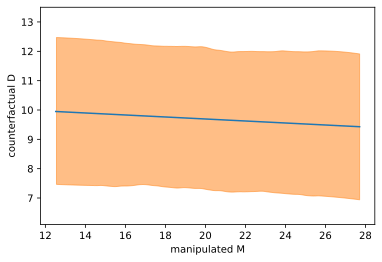

In [45]:
fig, ax = plt.subplots()

ax.plot(dstd_M(M_seq), dstd_D(D_mu_seq.mean(axis=1)))
az.plot_hdi(dstd_M(M_seq), dstd_D(D_sim_seq), hdi_prob=.89, ax=ax)
ax.set_ylim(d['Divorce'].min(), d['Divorce'].max())
ax.set_xlabel('manipulated M')
ax.set_ylabel('counterfactual D')

plt.show()

### Code 5.28

In [46]:
d = pd.read_csv('../data/milk.csv', sep=';')

In [47]:
d.describe()

,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
count,29.000,29.000,29.000,29.000,29.000,17.000
mean,0.642,33.990,16.403,49.606,14.727,67.576
std,0.161,14.287,4.847,14.055,24.770,5.969
min,0.460,3.930,7.370,27.090,0.120,55.160
25%,0.490,21.220,13.000,37.800,1.620,64.540
50%,0.600,36.840,15.800,48.640,3.470,68.850
75%,0.730,46.080,20.770,60.120,10.720,71.260
max,0.970,55.510,25.300,71.910,97.720,76.300


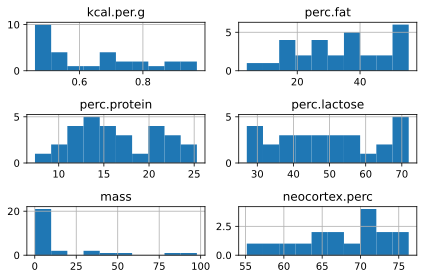

In [48]:
d.hist(bins=10)
plt.tight_layout()
plt.show()

### Code 5.29

In [49]:
std_K, dstd_K = create_standardizer_destandardizer(d['kcal.per.g'])
std_N, dstd_N = create_standardizer_destandardizer(d['neocortex.perc'])
std_M, dstd_M = create_standardizer_destandardizer(np.log(d['mass']))

In [50]:
d['K'] = std_K(d['kcal.per.g'])
d['N'] = std_N(d['neocortex.perc'])
d['M'] = std_M(np.log(d['mass']))

### Code 5.30

In [51]:
with pm.Model() as model_55_draft:
    a = pm.Normal('a', 0, 1)
    bN = pm.Normal('bN', 0, 1)
    N = pm.Data('N', d['N'])
    mu = a + bN * N
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('K', mu, sigma, observed=d['K'])
    trace_55_draft = pm.sample()

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'a': array(0.), 'bN': array(0.), 'sigma_log__': array(-0.36651292)}

Initial evaluation results:
a             -0.920
bN            -0.920
sigma_log__   -1.060
K                NaN
Name: Log-probability of test_point, dtype: float64

### Code 5.31

In [52]:
d['neocortex.perc']

0    55.160
1       NaN
2       NaN
3       NaN
4       NaN
5    64.540
6    64.540
7    67.640
8       NaN
9    68.850
10   58.850
11   61.690
12   60.320
13      NaN
14      NaN
15   69.970
16      NaN
17   70.410
18      NaN
19   73.400
20      NaN
21   67.530
22      NaN
23   71.260
24   72.600
25      NaN
26   70.240
27   76.300
28   75.490
Name: neocortex.perc, dtype: float64

### Code 5.32

In [53]:
dcc = d.dropna(subset=['K', 'N', 'M'])

### Code 5.33

In [54]:
with pm.Model() as model_55_draft:
    a = pm.Normal('a', 0, 1)
    bN = pm.Normal('bN', 0, 1)
    N = pm.Data('N', dcc['N'])
    mu = pm.Deterministic('mu', a + bN * N)
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('K', mu, sigma, observed=dcc['K'])
    trace_55_draft = pm.sample()
    

<ipython-input-54-1ac59e1bb9c5>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_55_draft = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bN, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


### Code 5.34

In [55]:
with model_55_draft:
    x_seq = np.linspace(-2, 2, 30)
    pm.set_data({'N': x_seq})
    mu = pm.sample_prior_predictive(50, var_names=['mu'])['mu']

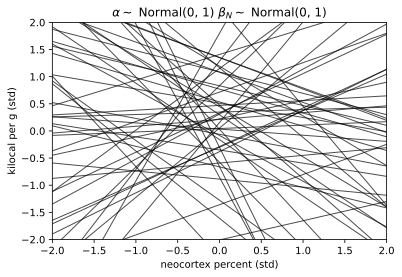

In [56]:
fig, ax = plt.subplots()

ax.set_title(r'$\alpha \sim$ Normal(0, 1) $\beta_N \sim $ Normal(0, 1)')
ax.set_xlabel('neocortex percent (std)')
ax.set_ylabel('kilocal per g (std)')

for i in range(mu.shape[0]):
    ax.plot(x_seq, mu[i, :], color='black', linewidth=1, alpha=.7)
    
ax.set_ylim(-2, 2)
ax.set_xlim(-2, 2)
plt.show()

### Code 5.35

In [57]:
with pm.Model() as model_55:
    a = pm.Normal('a', 0, .2)
    bN = pm.Normal('bN', 0, .5)
    N = pm.Data('N', dcc['N'])
    mu = pm.Deterministic('mu', a + bN * N)
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('K', mu, sigma, observed=dcc['K'])
    trace_55 = pm.sample(5000, tune=10000)
    

<ipython-input-57-ffcfe90ad2ab>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_55 = pm.sample(5000, tune=10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bN, a]


Sampling 2 chains for 10_000 tune and 5_000 draw iterations (20_000 + 10_000 draws total) took 20 seconds.


In [58]:
with deepcopy(model_55):
    x_seq = np.linspace(-2, 2, 30)
    pm.set_data({'N': x_seq})
    mu = pm.sample_prior_predictive(50, var_names=['mu'])['mu']

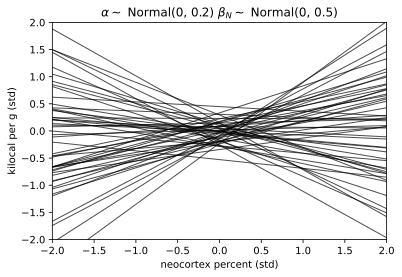

In [59]:
fig, ax = plt.subplots()

ax.set_title(r'$\alpha \sim$ Normal(0, 0.2) $\beta_N \sim $ Normal(0, 0.5)')
ax.set_xlabel('neocortex percent (std)')
ax.set_ylabel('kilocal per g (std)')

for i in range(mu.shape[0]):
    ax.plot(x_seq, mu[i, :], color='black', linewidth=1, alpha=.7)

ax.set_ylim(-2, 2)
ax.set_xlim(-2, 2)

plt.show()

### Code 5.36

In [60]:
az.summary(trace_55, kind='stats', hdi_prob=.89, var_names=['a', 'bN', 'sigma'])

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.040,0.159,-0.209,0.294
bN,0.129,0.247,-0.275,0.515
sigma,1.110,0.199,0.800,1.398


### Code 5.37

In [61]:
xseq = np.linspace(d['N'].min() - .15, d['N'].max() + .15, 30)
with deepcopy(model_55):
    pm.set_data({'N': xseq})
    mu = pm.sample_posterior_predictive(trace_55, var_names=['mu'])['mu']

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


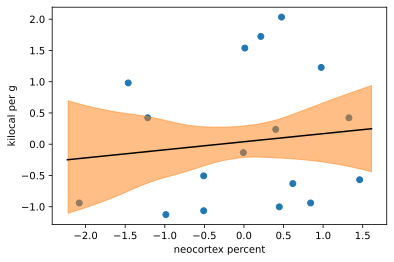

In [62]:
fig, ax = plt.subplots()
ax.scatter(dcc['N'], dcc['K'])
ax.plot(xseq, mu.mean(axis=0), color='black')
az.plot_hdi(xseq, mu, hdi_prob=.89, ax=ax)
ax.set_xlabel('neocortex percent')
ax.set_ylabel('kilocal per g')

plt.show()

### Code 5.38

In [63]:
with pm.Model() as model_56:
    a = pm.Normal('a', 0, .2)
    bM = pm.Normal('bM', 0, .5)
    M = pm.Data('M', dcc['M'])
    mu = pm.Deterministic('mu', a + bM*M)
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('K', mu, sigma, observed=dcc['K'])
    trace_56 = pm.sample(5000, tune=10_000)

<ipython-input-63-dc18b478879b>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_56 = pm.sample(5000, tune=10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, a]


Sampling 2 chains for 10_000 tune and 5_000 draw iterations (20_000 + 10_000 draws total) took 19 seconds.


In [64]:
az.summary(trace_56, kind='stats', hdi_prob=.89, var_names=['a', 'bM', 'sigma'])

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.042,0.158,-0.217,0.287
bM,-0.270,0.212,-0.594,0.074
sigma,1.057,0.195,0.750,1.330


In [65]:
xseq = np.linspace(d['M'].min() - .15, d['M'].max() + .15, 30)
with deepcopy(model_56):
    pm.set_data({'M': xseq})
    mu = pm.sample_posterior_predictive(trace_56, var_names=['mu'])['mu']

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


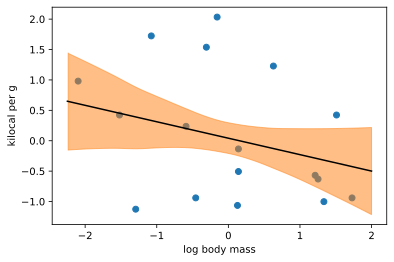

In [66]:
fig, ax = plt.subplots()
ax.scatter(dcc['M'], dcc['K'])
ax.plot(xseq, mu.mean(axis=0), color='black')
az.plot_hdi(xseq, mu, hdi_prob=.89, ax=ax)
ax.set_xlabel('log body mass')
ax.set_ylabel('kilocal per g')

plt.show()

### Code 5.39

In [67]:
with pm.Model() as model_57:
    a = pm.Normal('a', 0, .2)
    bM = pm.Normal('bM', 0, .5)
    bN = pm.Normal('bN', 0, .5)
    
    M = pm.Data('M', dcc['M'])
    N = pm.Data('N', dcc['N'])
    
    mu = pm.Deterministic('mu', a + bM*M + bN*N)
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('K', mu, sigma, observed=dcc['K'])
    
    trace_57 = pm.sample(5000, tune=10_000)

<ipython-input-67-19e7ddfe6bca>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_57 = pm.sample(5000, tune=10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bN, bM, a]


Sampling 2 chains for 10_000 tune and 5_000 draw iterations (20_000 + 10_000 draws total) took 23 seconds.


In [68]:
az.summary(trace_57, kind='stats', hdi_prob=.89, var_names=['a', 'bN', 'bM', 'sigma'])

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.059,0.148,-0.170,0.298
bN,0.599,0.282,0.165,1.054
bM,-0.639,0.249,-1.043,-0.258
sigma,0.869,0.183,0.592,1.126


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


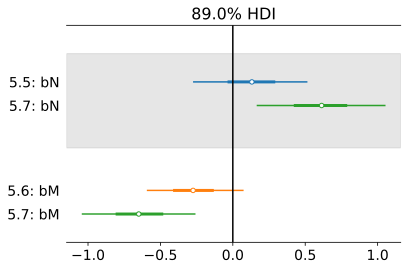

In [69]:
fig, ax = plt.subplots()
az.plot_forest(
    [trace_55, trace_56, trace_57],
    var_names=['bN', 'bM'],
    model_names=['5.5', '5.6', '5.7'],
    combined=True,
    hdi_prob=.89,
    ax=ax
)
ax.axvline(0, color='black')
plt.show()

### Code 5.41

In [70]:
xseq_N = np.linspace(d['N'].min() - .15, d['N'].max() + .15, 30)
xseq_M = np.linspace(d['M'].min() - .15, d['M'].max() + .15, 30)

with deepcopy(model_57):
    pm.set_data({'N': xseq_N, 'M': np.zeros(len(xseq_N))})
    mu1 = pm.sample_posterior_predictive(trace_57, var_names=['mu'])['mu']
    pm.set_data({'M': xseq_M, 'N': np.zeros(len(xseq_N))})
    mu2 = pm.sample_posterior_predictive(trace_57, var_names=['mu'])['mu']
    

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


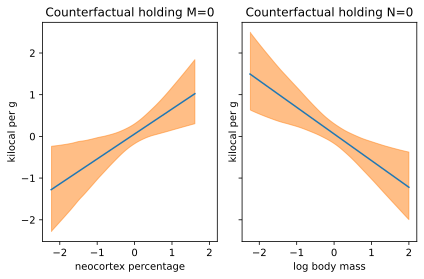

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)

ax1.set_title('Counterfactual holding M=0')
ax1.set_xlabel('neocortex percentage')
ax1.set_ylabel('kilocal per g')
ax1.plot(xseq_N, mu1.mean(axis=0))
az.plot_hdi(xseq_N, mu1, hdi_prob=.89, ax=ax1)

ax2.set_title('Counterfactual holding N=0')
ax2.set_xlabel('log body mass')
ax2.set_ylabel('kilocal per g')
ax2.plot(xseq_M, mu2.mean(axis=0))
az.plot_hdi(xseq_M, mu2, hdi_prob=.89, ax=ax2)


fig.tight_layout()
plt.show()

### Code 5.42

In [72]:
# M -> K <- N
# M -> N

n = 100
M = np.random.normal(size=n)
N = np.random.normal(loc=M)
K = np.random.normal(loc=N-M)
d_sim = pd.DataFrame({'K': K, 'N': N,'M': M})

### Code 5.43

In [73]:
# M -> K <- N
# N -> M

n = 100
N = stats.norm().rvs(n)
M = stats.norm(N).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim2 = pd.DataFrame({"K": K, "M": M, "N": N})

# M -> K <- N
# M <- U -> N

n = 100
U = stats.norm().rvs(n)
N = stats.norm(U).rvs(n)
M = stats.norm(U).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim3 = pd.DataFrame({"K": K, "M": M, "N": N})

### Code 5.45

In [74]:
d = pd.read_csv('../data/Howell1.csv', sep=';')

In [75]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


### Code 5.46

In [76]:
mu_female = np.random.normal(loc=178, scale=20, size=10_000)
mu_male = np.random.normal(loc=178, scale=20, size=10_000) + np.random.normal(loc=0, scale=10, size=10_000)
dd = pd.DataFrame({'mu_female': mu_female, 'mu_male': mu_male})

In [77]:
dd.describe()

,mu_female,mu_male
count,"10,000.000","10,000.000"
mean,178.091,178.214
std,20.092,22.516
min,89.359,92.648
25%,164.409,163.290
50%,178.083,178.154
75%,191.912,193.150
max,250.585,289.685


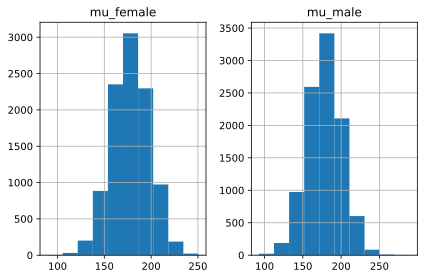

In [78]:
dd.hist()
plt.tight_layout()
plt.show()

### Code 5.47 

In [79]:
d['sex'] = np.where(d['male'] == 1, 1, 0)
d['sex']

0      1
1      0
2      0
3      1
4      0
      ..
539    1
540    1
541    0
542    1
543    1
Name: sex, Length: 544, dtype: int64

### Code 5.48

In [80]:
with pm.Model() as model_58:
    a = pm.Normal('a', 178, 20, shape=2)
    mu = a[d['sex'].values]
    sigma = pm.Uniform('sigma', 0, 50)
    height = pm.Normal('height', mu, sigma, observed=d['height'])
    trace_58 = pm.sample()

<ipython-input-80-2d376eb32126>:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_58 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [81]:
az.summary(trace_58, hdi_prob=.89, kind='stats')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a[0],134.943,1.646,132.233,137.561
a[1],142.592,1.760,139.717,145.383
sigma,27.416,0.838,26.203,28.872


### Code 5.49

In [82]:
diff_fm = pd.Series(trace_58['a'][:, 0] - trace_58['a'][:, 1])
diff_fm.describe(percentiles=[.055, .945])

count   2,000.000
mean       -7.650
std         2.400
min       -15.807
5.5%      -11.571
50%        -7.614
94.5%      -3.691
max         1.102
dtype: float64

### Code 5.50

In [83]:
d = pd.read_csv('../data/milk.csv', sep=';')

In [84]:
sorted(d['clade'].unique().tolist())

['Ape', 'New World Monkey', 'Old World Monkey', 'Strepsirrhine']

### Code 5.51

In [85]:
d['clade'] = d['clade'].astype('category')

### Code 5.52 

In [86]:
d['K'] = (d['kcal.per.g'] - d['kcal.per.g'].mean()) / d['kcal.per.g'].std()

In [87]:
with pm.Model() as model_59:
    a = pm.Normal('a', 0, .5, shape=d['clade'].nunique())
    mu = a[d['clade'].cat.codes]
    sigma = pm.Normal('sigma', 1)
    K = pm.Normal('K', mu, sigma, observed=d['K'])
    trace_59 = pm.sample()

<ipython-input-87-3d00cc42b159>:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_59 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


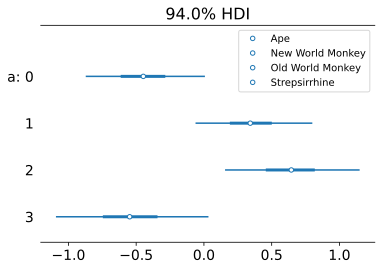

In [88]:
fig, ax = plt.subplots()
az.plot_forest(trace_59, var_names=['a'], ax=ax, combined=True)
ax.legend(d['clade'].cat.categories)

### Code 5.53

In [89]:
d["house"] = np.random.randint(0, 4, size=d.shape[0])

### Code 5.54

In [90]:
with pm.Model() as model_510:
    sigma = pm.Exponential("sigma", 1)
    mu_house = pm.Normal("mu_house", 0, 0.5, shape=d["house"].nunique())
    mu_clade = pm.Normal("mu_clade", 0, 0.5, shape=d["clade"].nunique())
    mu = mu_clade[d["clade"].cat.codes] + mu_house[d["house"].values]

    K = pm.Normal("K", mu, sigma, observed=d["K"])

    trace_510 = pm.sample()

az.summary(trace_510, var_names=["mu_clade", "mu_house"])

<ipython-input-90-40589284dd1d>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_510 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_clade, mu_house, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_clade[0],-0.364,0.283,-0.909,0.123,0.008,0.005,"1,423.000","1,330.000",1.000
mu_clade[1],0.361,0.277,-0.167,0.866,0.008,0.006,"1,250.000","1,436.000",1.000
mu_clade[2],0.682,0.302,0.118,1.232,0.008,0.006,"1,506.000","1,483.000",1.000
mu_clade[3],-0.476,0.315,-1.084,0.111,0.008,0.006,"1,484.000","1,213.000",1.000
mu_house[0],-0.129,0.272,-0.656,0.366,0.008,0.006,"1,311.000","1,513.000",1.000
mu_house[1],-0.002,0.318,-0.623,0.571,0.008,0.007,"1,710.000","1,628.000",1.000
mu_house[2],-0.225,0.260,-0.684,0.297,0.007,0.006,"1,258.000","1,460.000",1.000
mu_house[3],0.578,0.356,-0.092,1.210,0.008,0.006,"1,854.000","1,697.000",1.000


## Practice

### 5E1. 

Which of the linear models below are multiple linear regressions?

- (1) $\mu_i = \alpha + \beta_{x_i}$
- (2) $\mu_i = \beta_x x_i + \beta_z z_i$
- (3) $\mu_i = \alpha + \beta(x_i − z_i)$
- (4) $\mu_i = \alpha + \beta_x x_i + \beta_z z_i$

**Answer:** (4)

### 5E2. 
Write down a multiple regression to evaluate the claim: *Animal diversity is linearly related to latitude, but only after controlling for plant diversity*. You just need to write down the model definition.

**Answer:**

- $L$: Latitude
- $P$: Plant Diversity
- $A$: Animal Diversity

$$
\alpha \sim Normal(0, 0.2) \\
\beta_L \sim Normal(0, 0.5) \\
\beta_P \sim Normal(0, 0.5) \\
\mu = \alpha + \beta_L L_i + \beta_P P_i \\
\sigma \sim Exponential(1) \\
A_i \sim Normal(\mu, \sigma)
$$

### 5E3. 

Write down a multiple regression to evaluate the claim: *Neither amount of funding nor size of laboratory is by itself a good predictor of time to PhD degree; but together these variables are both positively associated with time to degree.* Write down the model definition and indicate which side of zero each slope parameter should be on.

**Answer:**

$$ 
T_i = \alpha + \beta_F F_i + \beta_S S_i \\
\beta_F > 0 \\
\beta_S > 0
$$

### 5E4. 

Suppose you have a single categorical predictor with 4 levels (unique values), labeled $A$, $B$, $C$ and $D$. Let $A_i$ be an indicator variable that is 1 where case $i$ is in category $A$. Also suppose $B_i$, $C_i$, and $D_i$ for the other categories. Now which of the following linear models are inferentially equivalent ways to include the categorical variable in a regression? Models are inferentially equivalent when it's possible to compute one posterior distribution from the posterior distribution of another model.

- (1) $\mu_i = \alpha + \beta_A A_i + \beta_B B_i + \beta_D D_i$
- (2) $\mu_i = \alpha + \beta_A A_i + \beta_B B_i + \beta_C C_i + \beta_D D_i$
- (3) $\mu_i = \alpha + \beta_B B_i + \beta_C C_i + \beta_D D_i$
- (4) $\mu_i = \alpha_A A_i + \alpha_B B_i + \alpha_C C_i + \alpha_D D_i$
- (5) $\mu_i = \alpha_A (1 − B_i − C_i − D_i) + \alpha_B B_i + \alpha_C C_i + \alpha_D D_i$

**Answer:** (2), (4) and (5)

(1) is not equivalent because value $A$, $B$, $D$ will be affected by one more uncertainty compared to $C$

(3) is equivalent to (1)


### 5M1. 
Invent your own example of a spurious correlation. An outcome variable should be correlated
with both predictor variables. But when both predictors are entered in the same model, the correlation
between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced).

In [91]:
T = np.random.normal(23, 5, size=1000)
S = np.round(np.clip(np.random.normal(T/5, 2), a_min=0, a_max=None), 0)
I = np.random.normal(T*10000, 30000)

d = pd.DataFrame({'T': T, 'S': S, 'I': I})

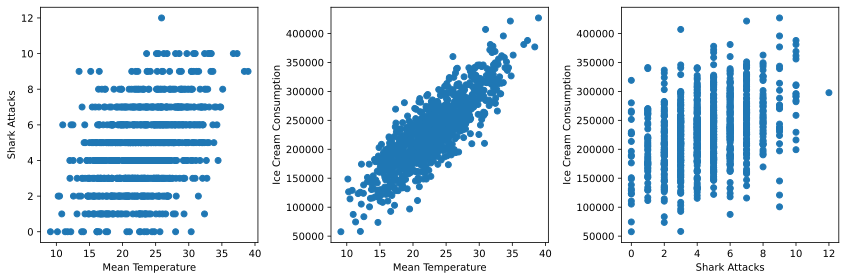

In [92]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.scatter(d['T'], d['S'])
ax1.set_xlabel('Mean Temperature')
ax1.set_ylabel('Shark Attacks')

ax2.scatter(d['T'], d['I'])
ax2.set_xlabel('Mean Temperature')
ax2.set_ylabel('Ice Cream Consumption')

ax3.scatter(d['S'], d['I'])
ax3.set_xlabel('Shark Attacks')
ax3.set_ylabel('Ice Cream Consumption')

fig.tight_layout()
plt.show()

In [93]:
std_T, dstd_T = create_standardizer_destandardizer(d['T'])
std_S, dstd_S = create_standardizer_destandardizer(d['S'])
std_I, dstd_I = create_standardizer_destandardizer(d['I'])

#### X=Shark 

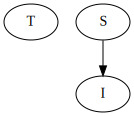

In [94]:
CausalGraphicalModel(
    nodes=['S', 'T', 'I'],
    edges=[
        ('S', 'I')
    ]
).draw()

In [95]:
with pm.Model() as model_1:
    α = pm.Normal('α', 0, .2)
    β_S = pm.Normal('β_S', 0, .5)
    S = pm.Data('S', std_S(d['S']))
    μ = pm.Deterministic('μ', α + β_S*S)
    σ = pm.Exponential('σ', 1)
    I = pm.Normal('I', μ, σ, observed=std_I(d['I']))
    trace_1 = pm.sample()

<ipython-input-95-7266eb09a422>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β_S, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [96]:
az.summary(trace_1, kind='stats', hdi_prob=.89, var_names=['α', 'β_S'])

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
α,0.000,0.030,-0.050,0.043
β_S,0.366,0.030,0.317,0.413


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<AxesSubplot:>

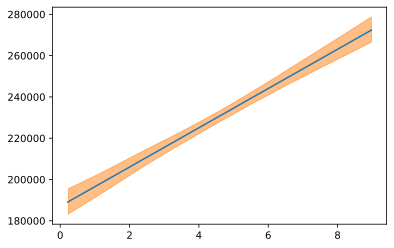

In [97]:
with deepcopy(model_1):
    xseq = np.linspace(-2, 2, 30)
    pm.set_data({'S': xseq})
    yseq = pm.sample_posterior_predictive(trace_1, var_names=['μ'])['μ']
    
fig, ax = plt.subplots(1, 1)
ax.plot(dstd_S(xseq), dstd_I(yseq.mean(axis=0)))
az.plot_hdi(dstd_S(xseq), dstd_I(yseq), hdi_prob=.89, ax=ax)

#### X=Temperature

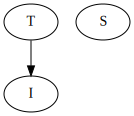

In [98]:
CausalGraphicalModel(
    nodes=['S', 'T', 'I'],
    edges=[
        ('T', 'I')
    ]
).draw()

In [99]:
with pm.Model() as model_2:
    α = pm.Normal('α', 0, .2)
    β_T = pm.Normal('β_T', 0, .5)
    T = pm.Data('T', std_T(d['T']))
    μ = pm.Deterministic('μ', α + β_T*T)
    σ = pm.Exponential('σ', 1)
    I = pm.Normal('I', μ, σ, observed=std_I(d['I']))
    trace_2 = pm.sample()

<ipython-input-99-19248b5bafc9>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_2 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β_T, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [100]:
az.summary(trace_2, kind='stats', hdi_prob=.89, var_names=['α', 'β_T'])

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
α,-0.000,0.017,-0.026,0.028
β_T,0.840,0.017,0.814,0.869


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<AxesSubplot:>

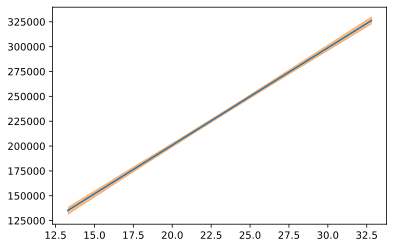

In [101]:
with deepcopy(model_2):
    xseq = np.linspace(-2, 2, 30)
    pm.set_data({'T': xseq})
    yseq = pm.sample_posterior_predictive(trace_2, var_names=['μ'])['μ']
    
fig, ax = plt.subplots(1, 1)
ax.plot(dstd_T(xseq), dstd_I(yseq.mean(axis=0)))
az.plot_hdi(dstd_T(xseq), dstd_I(yseq), hdi_prob=.89, ax=ax)

### X=[Shark, Temperature]

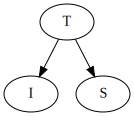

In [102]:
dag = CausalGraphicalModel(
    nodes=['S', 'T', 'I'],
    edges=[
        ('T', 'S'),
        ('T', 'I')
    ]
)
dag.draw()

In [103]:
dag.get_all_independence_relationships()

[('I', 'S', {'T'})]

In [104]:
with pm.Model() as model_3:
    α = pm.Normal('α', 0, .2)
    β_S = pm.Normal('β_S', 0, .5)
    β_T = pm.Normal('β_T', 0, .5)
    S = pm.Data('S', std_S(d['S']))
    T = pm.Data('T', std_T(d['T']))
    μ = pm.Deterministic('μ', α + β_S*S + β_T*T)
    σ = pm.Exponential('σ', 1)
    I = pm.Normal('I', μ, σ, observed=std_I(d['I']))
    trace_3 = pm.sample()

<ipython-input-104-43e7a44e93c6>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_3 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β_T, β_S, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [105]:
az.summary(trace_3, kind='stats', hdi_prob=.89, var_names=['α', 'β_S', 'β_T'])

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
α,0.000,0.018,-0.027,0.029
β_S,0.027,0.018,-0.003,0.055
β_T,0.829,0.019,0.799,0.859


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


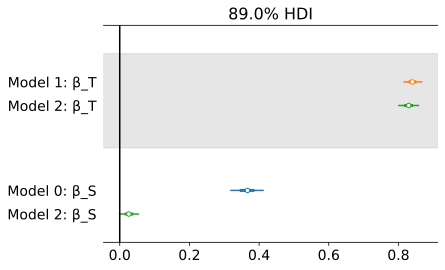

In [106]:
fig, ax = plt.subplots()
az.plot_forest([trace_1, trace_2, trace_3], var_names=['β_T', 'β_S'], hdi_prob=.89, combined=True, ax=ax)
ax.axvline(0, color='black')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


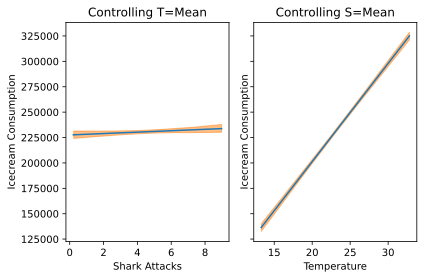

In [107]:
with deepcopy(model_3):
    xseq = np.linspace(-2, 2, 30)
    pm.set_data({'S': xseq, 'T': np.zeros(len(xseq))})
    yseq_controlling_T = pm.sample_posterior_predictive(trace_3, var_names=['μ'])['μ']
    pm.set_data({'T': xseq, 'S': np.zeros(len(xseq))})
    yseq_controlling_S = pm.sample_posterior_predictive(trace_3, var_names=['μ'])['μ']

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(dstd_S(xseq), dstd_I(yseq_controlling_T.mean(axis=0)))
az.plot_hdi(dstd_S(xseq), dstd_I(yseq_controlling_T), hdi_prob=.89, ax=ax1)
ax1.set_xlabel('Shark Attacks')
ax1.set_ylabel('Icecream Consumption')
ax1.set_title('Controlling T=Mean')

ax2.plot(dstd_T(xseq), dstd_I(yseq_controlling_S.mean(axis=0)))
az.plot_hdi(dstd_T(xseq), dstd_I(yseq_controlling_S), hdi_prob=.89, ax=ax2)
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Icecream Consumption')
ax2.set_title('Controlling S=Mean')

fig.tight_layout()
plt.show()

### 5M2.
Invent your own example of a masked relationship. An outcome variable should be correlated
with both predictor variables, but in opposite directions. And the two predictor variables should be
correlated with one another.

In [110]:
X = np.random.normal(size=50)
Y = np.random.normal(X)
Z = np.random.normal(2 * X + 2 * Y)

d = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

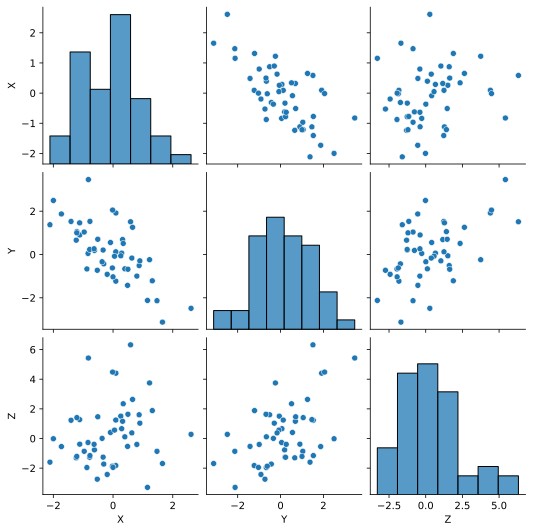

In [113]:
sns.pairplot(d)

#### X -> Z

[('Y', 'Z', set()), ('Y', 'Z', {'X'}), ('Y', 'X', set()), ('Y', 'X', {'Z'})]


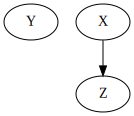

In [116]:
dag = CausalGraphicalModel(
    nodes=['X', 'Y', 'Z'],
    edges=[
        ('X', 'Z'),
    ]
)
print(dag.get_all_independence_relationships())
dag.draw()

#### Y -> Z

[('Y', 'Z', set()), ('Y', 'Z', {'X'}), ('Y', 'X', set()), ('Y', 'X', {'Z'})]


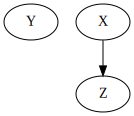

In [117]:
dag = CausalGraphicalModel(
    nodes=['X', 'Y', 'Z'],
    edges=[
        ('X', 'Z')
    ]
)
print(dag.get_all_independence_relationships())
dag.draw()

#### X, Y -> Z

[('Y', 'X', set())]


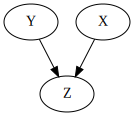

In [118]:
dag = CausalGraphicalModel(
    nodes=['X', 'Y', 'Z'],
    edges=[
        ('X', 'Z'),
        ('Y', 'Z'),
    ]
)
print(dag.get_all_independence_relationships())
dag.draw()

#### X -> Y | X, Y -> Z

[]


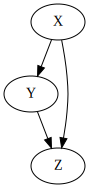

In [119]:
dag = CausalGraphicalModel(
    nodes=['X', 'Y', 'Z'],
    edges=[
        ('X', 'Z'),
        ('Y', 'Z'),
        ('X', 'Y'),
    ]
)
print(dag.get_all_independence_relationships())
dag.draw()

### 5M3.
It is sometimes observed that the best predictor of fire risk is the presence of firefighters—
States and localities with many firefighters also have more fires. Presumably firefighters do not cause
fires. Nevertheless, this is not a spurious correlation. Instead fires cause firefighters. Consider the
same reversal of causal inference in the context of the divorce and marriage data. How might a high
divorce rate cause a higher marriage rate? Can you think of a way to evaluate this relationship, using
multiple regression?

### 5M4.
In the divorce data, States with high numbers of members of the Church of Jesus Christ of
Latter-day Saints (LDS) have much lower divorce rates than the regression models expected. Find a
list of LDS population by State and use those numbers as a predictor variable, predicting divorce rate
using marriage rate, median age at marriage, and percent LDS population (possibly standardized).
You may want to consider transformations of the raw percent LDS variable.

### 5M5.
One way to reason through multiple causation hypotheses is to imagine detailed mechanisms
through which predictor variables may influence outcomes. For example, it is sometimes argued that
the price of gasoline (predictor variable) is positively associated with lower obesity rates (outcome
variable). However, there are at least two important mechanisms by which the price of gas could
reduce obesity. First, it could lead to less driving and therefore more exercise. Second, it could lead to
less driving, which leads to less eating out, which leads to less consumption of huge restaurant meals.
Can you outline one or more multiple regressions that address these two mechanisms? Assume you
can have any predictor data you need.

### 5H1.
In the divorce example, suppose the DAG is: $M → A → D$. What are the implied conditional independencies of the graph? Are the data consistent with it?

### 5H2.
Assuming that the DAG for the divorce example is indeed $M → A → D$, fit a new model and use it to estimate the counterfactual effect of halving a State’s marriage rate M. Use the counterfactual example from the chapter (starting on page 140) as a template.

### 5H3.
Return to the milk energy model, `m5.7`. Suppose that the true causal relationship among the
variables is:

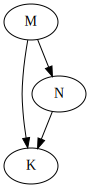

In [169]:
dag = CausalGraphicalModel(
    nodes=['M', 'N', 'K'],
    edges=[
        ('M', 'N'),
        ('M', 'K'),
        ('N', 'K')
    ]
)
dag.draw()

Now compute the counterfactual effect on $K$ of doubling $M$. You will need to account for both the
direct and indirect paths of causation. Use the counterfactual example from the chapter (starting on
page 140) as a template.

### 5H4.
Here is an open practice problem to engage your imagination. In the divorce date, States in the southern United States have many of the highest divorce rates. Add the South indicator variable to the analysis. First, draw one or more DAGs that represent your ideas for how Southern American culture might influence any of the other three variables ($D$, $M$ or $A$). Then list the testable implications of your DAGs, if there are any, and fit one or more models to evaluate the implications. What do you think the influence of “Southerness” is?

## Figures

### Figure 5.4

In [ ]:
d = pd.read_csv('../data/WaffleDivorce.csv', sep=';')

std_D, dstd_D = create_standardizer_destandardizer(d['Divorce'])
std_M, dstd_M = create_standardizer_destandardizer(d['Marriage'])
std_A, dstd_A = create_standardizer_destandardizer(d['MedianAgeMarriage'])

In [ ]:
with pm.Model() as model_A_to_M:
    a = pm.Normal('a', 0, .2)
    bA = pm.Normal('bA', 0, .5)
    mu = a + bA * std_A(d['MedianAgeMarriage'])
    sigma = pm.Exponential('sigma', 1)
    marriage = pm.Normal('marriage', mu, sigma, observed=std_M(d['Marriage']))
    trace_A_to_M = pm.sample(return_inferencedata=False)

AM_mean = (trace_A_to_M['a'] + np.outer(std_A(d['MedianAgeMarriage']), trace_A_to_M['bA'])).mean(axis=1)
AM_resid = std_M(d['Marriage']) - AM_mean

with pm.Model() as model_AMR_to_D:
    a = pm.Normal('a', 0, .2)
    bAMR = pm.Normal('bAMR', 0, .5)
    mu = a + bAMR * AM_resid
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('divorce', mu, sigma, observed=std_D(d['Divorce']))
    trace_AMR_to_D = pm.sample(return_inferencedata=False)

In [ ]:
with pm.Model() as model_M_to_A:
    a = pm.Normal('a', 0, .2)
    bM = pm.Normal('bM', 0, .5)
    mu = a + bM * std_M(d['Marriage'])
    sigma = pm.Exponential('sigma', 1)
    age = pm.Normal('age', mu, sigma, observed=std_A(d['MedianAgeMarriage']))
    trace_M_to_A = pm.sample(return_inferencedata=False)

MA_mean = (trace_M_to_A['a'] + np.outer(std_M(d['Marriage']), trace_M_to_A['bM'])).mean(axis=1)
MA_resid = std_A(d['MedianAgeMarriage']) - MA_mean

with pm.Model() as model_MAR_to_D:
    a = pm.Normal('a', 0, .2)
    bMAR = pm.Normal('bMAR', 0, .5)
    mu = a + bMAR * MA_resid
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('divorce', mu, sigma, observed=std_D(d['Divorce']))
    trace_MAR_to_D = pm.sample(return_inferencedata=False)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6))

# Age to Marriage
axes[0, 0].set_xlabel('Age at Marriage')
axes[0, 0].set_ylabel('Marriage Rate')
axes[0, 0].scatter(d['MedianAgeMarriage'], d['Marriage'], facecolors='none', edgecolors='blue', s=10)

xline = std_A(np.linspace(d['MedianAgeMarriage'].min(), d['MedianAgeMarriage'].max()))
yline = (trace_A_to_M['a'] + np.outer(xline, trace_A_to_M['bA'])).mean(axis=1)
axes[0, 0].plot(dstd_A(xline), dstd_M(yline), color='black', linewidth=1)
axes[0, 0].vlines(d['MedianAgeMarriage'], d['Marriage'], dstd_M(AM_mean), color='black', linewidth=1)


# (Age to Marriage residuals) to Divorce
axes[1, 0].set_xlabel('Marriage Rate Residuals')
axes[1, 0].set_ylabel('Divorce Rate')
axes[1, 0].scatter(AM_resid, d['Divorce'], facecolors='none', edgecolors='blue', s=10)
axes[1, 0].axvline(0, color='black', linestyle='--', alpha=.5)

xline = np.linspace(AM_resid.min(), AM_resid.max(), 50)
yline = (trace_AMR_to_D['a'] + np.outer(xline, trace_AMR_to_D['bAMR'])).T
axes[1, 0].plot(xline, dstd_D(yline.mean(axis=0)), color='black', linewidth=1)
az.plot_hdi(xline, dstd_D(yline), hdi_prob=.89, ax=axes[1, 0])


# Marriage to Age
axes[0, 1].set_ylabel('Age at Marriage')
axes[0, 1].set_xlabel('Marriage Rate')
axes[0, 1].scatter(d['Marriage'], d['MedianAgeMarriage'], facecolors='none', edgecolors='blue', s=10)

xline = std_M(np.linspace(d['Marriage'].min(), d['Marriage'].max()))
yline = (trace_M_to_A['a'] + np.outer(xline, trace_M_to_A['bM'])).mean(axis=1)
axes[0, 1].plot(dstd_M(xline), dstd_A(yline), color='black', linewidth=1)
axes[0, 1].vlines(d['Marriage'], d['MedianAgeMarriage'], dstd_A(MA_mean), color='black', linewidth=1)


# (Marriage to Age residuals) to Divorce
axes[1, 1].set_xlabel('Age at Marriage Residuals')
axes[1, 1].set_ylabel('Divorce Rate')
axes[1, 1].scatter(MA_resid, d['Divorce'], facecolors='none', edgecolors='blue', s=10)
axes[1, 1].axvline(0, color='black', linestyle='--', alpha=.5)

xline = np.linspace(MA_resid.min(), MA_resid.max(), 50)
yline = (trace_MAR_to_D['a'] + np.outer(xline, trace_MAR_to_D['bMAR'])).T
axes[1, 1].plot(xline, dstd_D(yline.mean(axis=0)), color='black', linewidth=1)
az.plot_hdi(xline, dstd_D(yline), hdi_prob=.89, ax=axes[1, 1])


fig.tight_layout()
plt.show()